In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
import zipfile, pathlib, shutil
zip_path = "archive.zip"
extract_to = pathlib.Path("data/catsdogs")

with zipfile.ZipFile(zip_path) as zf:
  zf.extractall(extract_to)

In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image

TRAIN_ROOT = '/content/data/catsdogs/train'
TEST_ROOT = '/content/data/catsdogs/test'

class CatsDogsDataset(Dataset):
  def __init__(self, root, transform = None):
    self.root = pathlib.Path(root)
    self.transform = transform
    self.label_map = {'cats': 0, 'dogs': 1}
    self.images = list(self.root.glob('*/*.jpg'))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_path = self.images[idx]
    img = Image.open(img_path).convert('RGB')
    label_str = img_path.parent.name
    y = self.label_map[label_str]
    if self.transform is not None:
      img = self.transform(img)
    return img, torch.tensor(y, dtype = torch.long)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset = CatsDogsDataset(TRAIN_ROOT, transform = transform)
test_dataset = CatsDogsDataset(TEST_ROOT, transform = transform)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torchvision import models
model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1).to(device)
for p in model.parameters():
  p.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


In [ ]:
def evaluate(model, loader):
  model.eval()
  correct = 0
  with torch.no_grad():
    for X, y in loader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      prediction = pred.argmax(dim = 1)
      correct += (prediction == y).sum().item()
  return correct/len(loader.dataset)


def train_one_epoch(model, loader, optimizer, criterion):
    model.train(); run_loss = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        run_loss += loss.item() * X.size(0)
    return run_loss / len(loader.dataset)

for epoch in range(10):
    loss = train_one_epoch(model, train_loader, optimizer, criterion)
    train_acc = evaluate(model, train_loader)
    val_acc   = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}: loss={loss:.4f} train={train_acc:.3f} val={val_acc:.3f}")

Epoch 1: loss=0.6200 train=0.864 val=0.843
Epoch 2: loss=0.3554 train=0.916 val=0.950
Epoch 3: loss=0.2428 train=0.932 val=0.986
Epoch 4: loss=0.1945 train=0.948 val=0.979
Epoch 5: loss=0.1624 train=0.968 val=0.979
Epoch 6: loss=0.1478 train=0.966 val=0.964
Epoch 7: loss=0.1364 train=0.971 val=0.957


KeyboardInterrupt: 

RNNs

10 20 15 30 40

In [ ]:
import zipfile, pathlib, shutil
zip_path = "mastercard.zip"
extract_to = pathlib.Path("data/mastercard")

with zipfile.ZipFile(zip_path) as zf:
  zf.extractall(extract_to)

In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv('/content/data/mastercard/Mastercard_stock_history.csv')
df.sort_values('Date', inplace = True)
print(df.head())


                        Date      Open      High       Low     Close  \
0  2006-05-25 00:00:00-04:00  3.677800  4.202548  3.668674  4.197985   
1  2006-05-26 00:00:00-04:00  4.225363  4.265517  4.025502  4.100336   
2  2006-05-30 00:00:00-04:00  4.103990  4.104902  3.910517  4.015467   
3  2006-05-31 00:00:00-04:00  4.047406  4.139579  4.047406  4.101250   
4  2006-06-01 00:00:00-04:00  4.100334  4.389630  4.097596  4.335786   

      Volume  Dividends  Stock Splits  
0  395343000        0.0           0.0  
1  103044000        0.0           0.0  
2   49898000        0.0           0.0  
3   30002000        0.0           0.0  
4   62344000        0.0           0.0  


In [ ]:
(num_samples, num_features)
(64, 32,32, 3)

NameError: name 'num_samples' is not defined

In [ ]:
close  = df['Close'].values
print(close)
print(close.shape)
close = close.reshape(-1, 1)
print(close.shape)

[  4.19798517   4.1003356    4.01546669 ... 527.64001465 531.98999023
 528.35498047]
(4733,)
(4733, 1)


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(close, test_size = 0.2, shuffle = False)
print(train.shape)
print(test.shape)


(3786, 1)
(947, 1)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
print(train.shape)
print(test.shape)
scaler = MinMaxScaler()  # scale to [0,1]
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

(3786, 1)
(947, 1)


In [ ]:
array = [0,1,2,3,4,5,6]
print(array[1:5])
print(array[5])

[1, 2, 3, 4]
5


In [ ]:
x = (samples, feature)
y = (sampes)

In [ ]:
10 20 40 60 80

In [ ]:
window = 30
class stockdataset(Dataset):
  def __init__(self, series, window):
    self.series = torch.tensor(series, dtype = torch.float32)
    self.window = window
  def __len__(self):
    return len(self.series)-self.window

  def __getitem__(self, idx):
    x = self.series[idx:idx+self.window]
    y = self.series[idx+self.window]

    return x, y.squeeze()

train_dataset = stockdataset(train_scaled, window)
test_dataset = stockdataset(test_scaled, window)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)




In [ ]:
class CNN2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, stride =1, padding =2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, stride =1, padding =2)
    self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, stride =1, padding =2)
    self.fc1 = nn.Linear(3200, 256)
    self.fc2 = nn.Linear(256, 10)
    self.pool = nn.MaxPool2d(2)
    self.dropout = nn.Dropout(0.2)


In [ ]:
10 20 30 40 50
48 20 10 20 1
            1.5
            2
            1.7
12
12
30


In [ ]:
class RNN(nn.Module):
  def __init__(self, hidden_size = 64, layers = 2):
    super().__init__()
    self.rnn = nn.RNN(input_size = 1, hidden_size = hidden_size, num_layers = layers, batch_first = True, dropout = 0.2)
    self.linear = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, h = self.rnn(x)
    #print(out.size())
    x = self.linear(out[:,-1,:]).squeeze(-1)
    return x


model = RNN().to(device)
optimizer   = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [ ]:
class LSTMForecast(nn.Module):
    def __init__(self, hidden=128, layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden, num_layers=layers,
                            batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):                # x: (B, W, 1)
        out, _ = self.lstm(x)
        last = out[:, -1, :]             # last timestep hidden
        return self.fc(last).squeeze(-1)             # (B, H)

model = LSTMForecast().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train(); run_loss = 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        run_loss += loss.item() * X.size(0)
    return run_loss / len(loader.dataset)

for epoch in range(10):
    loss = train_one_epoch(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}: loss={loss:.4f}")

Epoch 1: loss=0.0170
Epoch 2: loss=0.0011
Epoch 3: loss=0.0009
Epoch 4: loss=0.0006
Epoch 5: loss=0.0006
Epoch 6: loss=0.0005
Epoch 7: loss=0.0005
Epoch 8: loss=0.0004
Epoch 9: loss=0.0004
Epoch 10: loss=0.0003


tensor(0.0914, device='cuda:0')


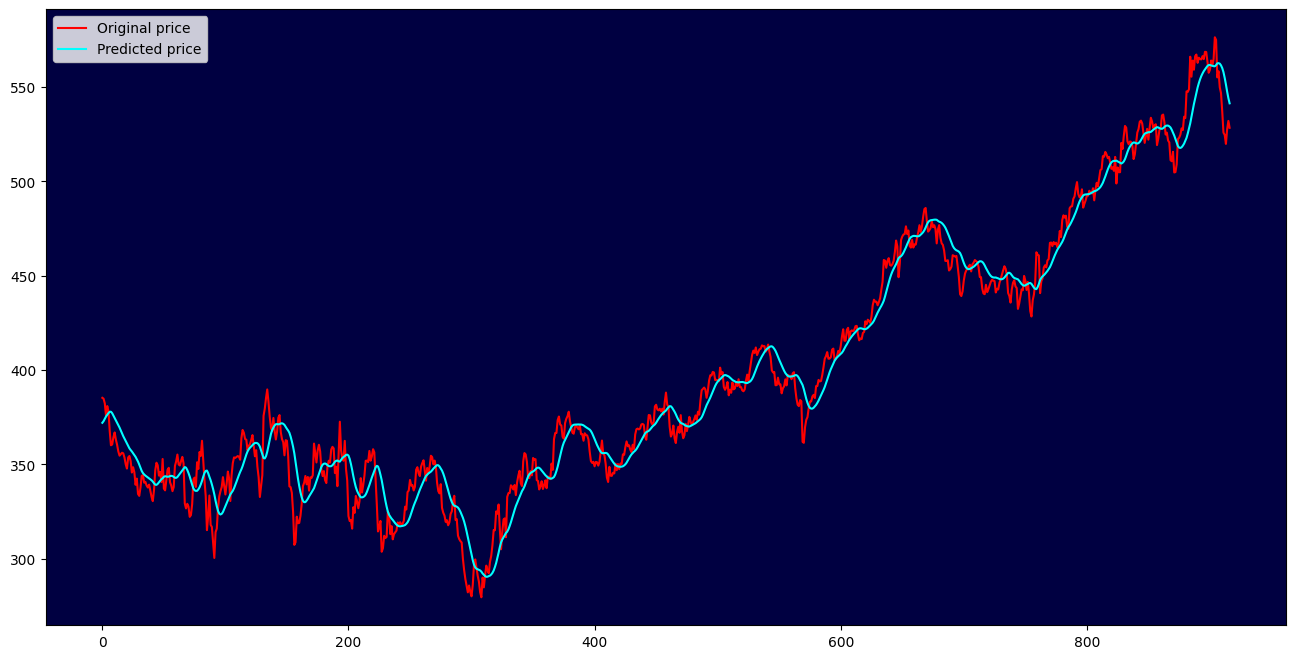

In [ ]:
def evaluateRNN(model, loader):
  model.eval()
  total = 0
  with torch.no_grad():
    preds = []
    true = []
    for X, y in loader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      preds = np.append(preds, pred.cpu().numpy())
      true = np.append(true, y.cpu().numpy())
      #pred = scaler.inverse_transform(pred.cpu().numpy().reshape(-1,1)).squeeze()
      #pred = torch.tensor(pred, dtype = torch.float32).to(device)
      mse  = (pred - y)**2
      total += torch.sum(mse)
  return total/len(loader), preds, true
mse, preds, true = evaluateRNN(model,test_loader)
print(mse)



predictions = scaler.inverse_transform(preds.reshape(-1,1))
y_test_scaled = scaler.inverse_transform(true.reshape(-1,1))

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(predictions, color='cyan', label='Predicted price')
plt.legend()
